## Current status
- The current goal is to make standard QAOA work with adiabatic-like trajectories.
- L-BFGS-B optimizer (bounded) needs a lot of layers to find the factorization solution. From $p \sim 40$ layers, the
angle trajectories stops being quasi-adiabatic: some oscillations and sudden drops appear for $\gamma$.
- BFGS (unbounded) finds the solution with fidelity $1$ using only $p \sim 30$ layers. For L-BFGS-B, we need more than
$100$ layers to achieve comparable results. BFGS doesn't reflect any similarity to adiabaticity.

### Things I've tried
- Multiple definitions for max_gamma ($\gamma \in [0, \text{max\_gamma}]$): using maximum E, norm of E, two or three times the original definition, etc.
- Multiple allowed intervals for $\beta$: $[0, \pi],~[0, 2\pi],~[0, \pi/2],~[-\pi/4, \pi/4],~\dots$
- Multiple optimizers: BFGS, L-BFGS-B, COBYLA, Nelder-Mead
- Multiple optimizer options: tolerances, maximum iterations, etc.
- Rescaling Hamiltonians: max_E $\rightarrow$ 1

### Things I've checked
- Cost Hamiltonians are defined correctly, encoding the solution in the ground state.
- For $p=1$ layer, multiple initializations converge to the same optimal point. The cost function only has one minimum
in the main branch for $\gamma$ and $\beta$.
- Gradients are computed correctly, double checked against the energy profile.
- Interpolation is computed correctly.

### Doubts
- I understand that it's been observed that optimal QAOA trajectories tend to mimic adiabatic passages for MaxCut and
QUBO problems. Is our problem really a QUBO problem?
- Should the trajectories be perfectly adiabatic or some oscillations are accepted?
- With current results (BFGS), can we draw any conclusions concerning adiabatic factorization?

### Next steps
- Explore adiabaticity in our method. Linear hamiltonian. N=39
- Try boundary approach with our method. N=39
- Explore N=51 or N=77.
- Prepare presentation with results: boundary vs best for standard, bounded (start with +-+-+) vs unbounded for linear (¿adiabatic?)

https://arxiv.org/pdf/2309.15162

## Preprocessing

In [1]:
from datetime import datetime, date
import math
import os
import warnings

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess
from IPython.display import display, Markdown, Latex

from qaoa_solver import QAOASolver
from utils import int_to_binary_str, compute_solution, compute_fidelity


pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        result['date'] = result_date
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state_populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)

experiment_results = experiment_results[(experiment_results['extended_qaoa']==False)]

In [3]:
Ns = sorted(experiment_results['N'].unique())
cost_Hs = sorted(experiment_results['cost_hamiltonian'].unique())

dfs = []

for N in Ns:
    for Hc in cost_Hs:
        solver = QAOASolver(N=N, cost_hamiltonian=Hc)
        Ec = [E.real for E in solver.Ec]
        df = pd.DataFrame({
            'N': [N],
            'cost_hamiltonian': [Hc],
            'Ec': [Ec]
        })
        dfs.append(df)

energies_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_df, how='left', on=['N', 'cost_hamiltonian'])
experiment_results['energy_max'] = experiment_results['Ec'].apply(lambda E: np.max(E))
experiment_results['energy_norm'] = experiment_results['Ec'].apply(lambda E: np.linalg.norm(E))
experiment_results['energy_avg'] = experiment_results['Ec'].apply(lambda E: np.average(E))

max_costs = experiment_results.groupby(['N', 'optimizer', 'setup'])['cost'].max().reset_index()
max_costs = max_costs.rename(columns={'cost': 'max_cost'})
experiment_results = experiment_results.merge(max_costs, how='left', on=['N', 'optimizer', 'setup'])
experiment_results['cost_rescaled'] = experiment_results['cost'] / experiment_results['max_cost']

In [4]:
plot_colors = [
    #[Dark ,    light]
    ["black",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#b8860b", "#ffd700"],  # Golden
    ["#cc4c02", "#fe9929"],  # Orange
    ["#a10694", "#c994c7"],  # Purple
    ["#8c510a", "#d8b365"],  # Brown
    ["#0868ac", "#43a2ca"],  # Cian
]

## Comparison between optimizers (N = 15)

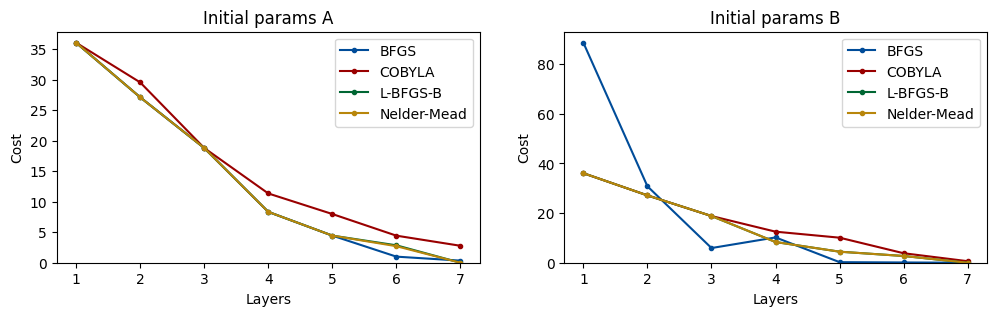

In [6]:
df = experiment_results[(experiment_results['N']==15) & (experiment_results['setup']=='standard')]
df = df.rename(columns={'optimizer_success': 'opt_succ'})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

for j, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_opt = df[(df.optimizer == optimizer)]

    df_a = df_opt[df_opt['gamma_0'].round(5)==0.00557]
    axs[0].set_title('Initial params A')
    axs[0].plot('layers', 'cost', data=df_a, marker='.', color=plot_colors[j+1][0], label=optimizer)

    df_b = df_opt[df_opt['gamma_0'].round(5)==0.00058]
    axs[1].set_title('Initial params B')
    axs[1].plot('layers', 'cost', data=df_b, marker='.', color=plot_colors[j+1][0], label=optimizer)

for ax in axs:
    ax.set_ylabel('Cost')
    ax.set_xlabel('Layers')
    ax.set_ylim(0)
    ax.legend(loc='best')

* L-BFGS-B is the best overall optimizer among the tested methods.
* Nelder-Mead's performance is similar to L-BFGS-B, but it is in the limit of scalability.
* COBYLA has a good performance as long as a huge amount of steps are allowed, making it the
slowest of the tested methods. Even with that, the optimizer finds difficulties to succeed in
multiple occasions. It doesn't seem very appropriate for our problem.
* Since BFGS is unbounded, it is the least predictable method due to the QAOA periodic nature: $\exp (i \gamma H)$.
Interestingly, BFGS found better solutions than L-BFGS-B for some layers and converged to the problem's solution. It is sensitive to initial conditions.

## Preliminar analysis

In [39]:
solver = QAOASolver(39, optimizer_method='BFGS', problem_hamiltonian='linear_H', cost_hamiltonian='abs_H')

# Max angle
max_gamma = 2*np.pi/max(solver.Ep)
print(max_gamma)

0.16534698176788384


**Optimal $\gamma$ for a given $\beta$**

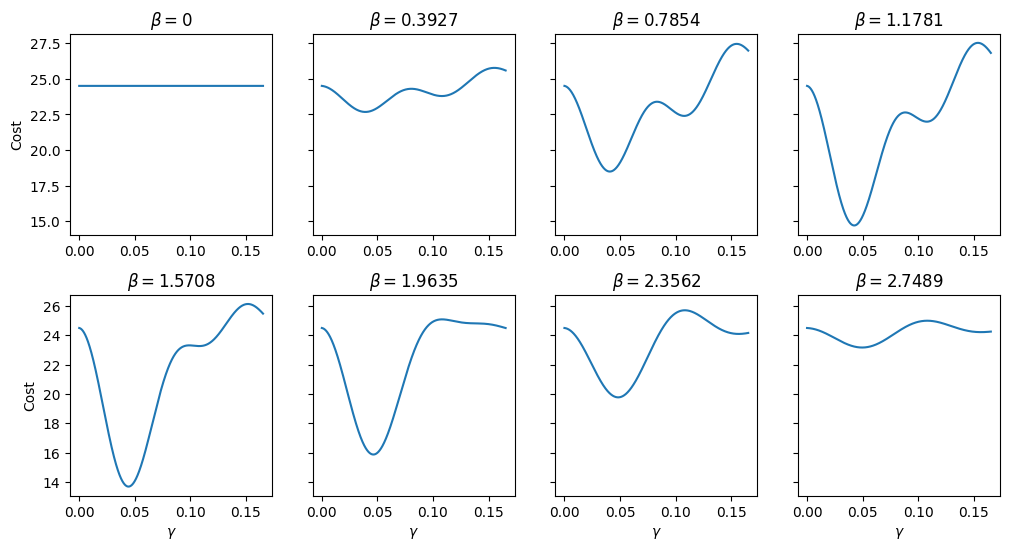

In [40]:
gammas = np.linspace(0, max_gamma, 10000)
betas = [0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8]

fig, axs = plt.subplots(2, 4, figsize=(12,6), sharey='row', sharex=False)
axs = axs.flatten()
fig.subplots_adjust(hspace=0.3)

for i, beta in enumerate(betas):
    cost = []

    for gamma in gammas:
        res = solver._compute_cost([gamma, beta])
        cost.append(res)

    df = pd.DataFrame({'gamma': gammas, 'cost': cost})

    
    axs[i].plot('gamma', 'cost', data=df)
    axs[i].set_title(f'$\\beta = {round(beta, 4)}$')
    if i in [0,4]:
        axs[i].set_ylabel('Cost')
    if i > 3:
        axs[i].set_xlabel('$\\gamma$')

## Standard protocol

## N=21

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
10,21,BFGS,1,0.007,1.5,[0.008278311895312],[1.529769538903815],32.774907,0.757476
0,21,L-BFGS-B,1,0.007,1.5,[0.008278311895116],[1.529769538820518],32.774907,0.757476


**2. State at layers=10**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
19,21,BFGS,10,0.007,1.5,5.701687e-22,1.0
9,21,L-BFGS-B,10,0.007,1.5,2.852285e-09,1.0


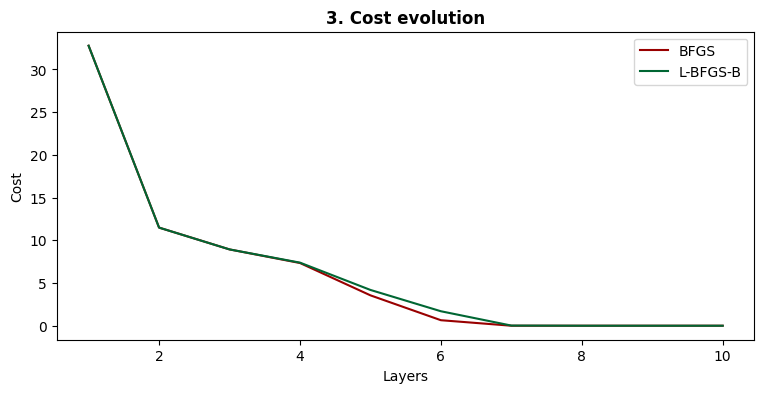

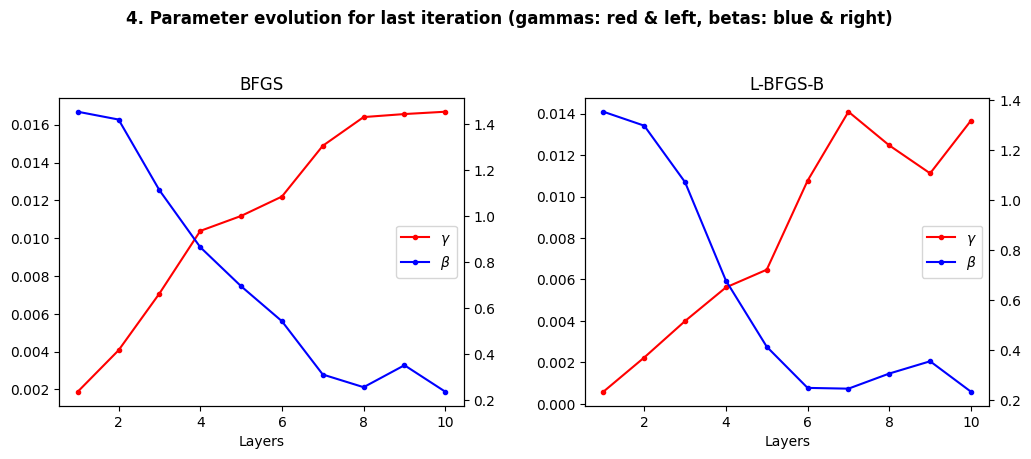

In [15]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## N=39

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
20,39,BFGS,1,0.005,0.4,[-0.34753293794883505],[0.835908434859794],593.776847,0.021937
70,39,L-BFGS-B,1,0.005,0.4,[0.0014424208694160002],[0.540105011347612],593.675930,0.036244


**2. State at layers=30**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
49,39,BFGS,30,0.005,0.4,0.016009,0.999343
99,39,L-BFGS-B,30,0.005,0.4,15.717973,0.386585


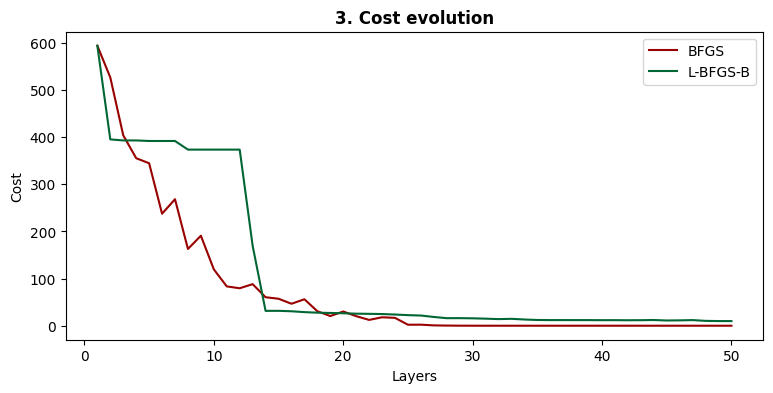

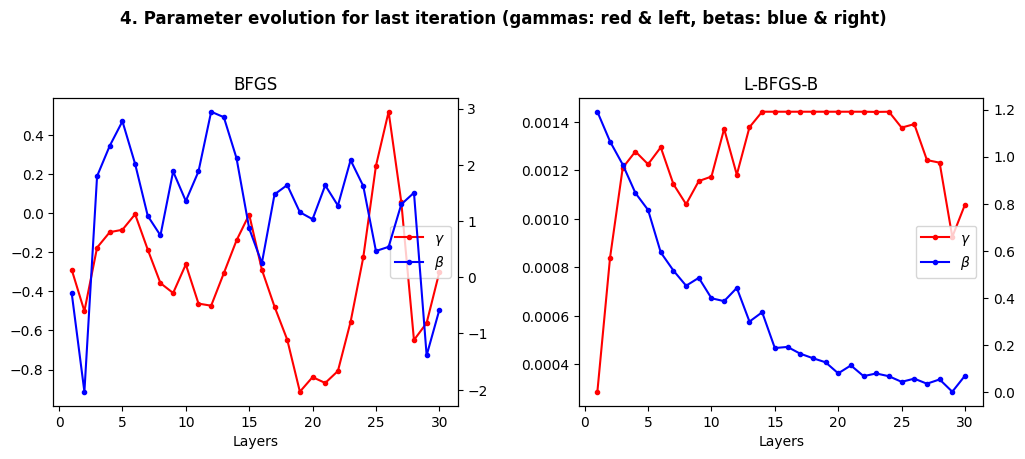

In [18]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = 30 # int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## N=51

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
290,51,BFGS,1,0.0001,0.8,[7.653187295904522e-05],[0.6251993693818071],1326.671435,0.02383
240,51,L-BFGS-B,1,0.0001,0.8,[7.6531872913161e-05],[0.625199370602673],1326.671435,0.02383


**2. State at layers=50**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
339,51,BFGS,50,0.0001,0.8,9.025102,0.069025
289,51,L-BFGS-B,50,0.0001,0.8,76.780489,0.155842


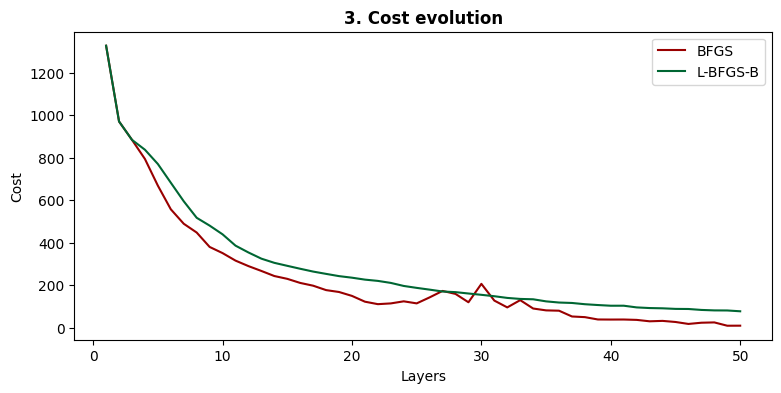

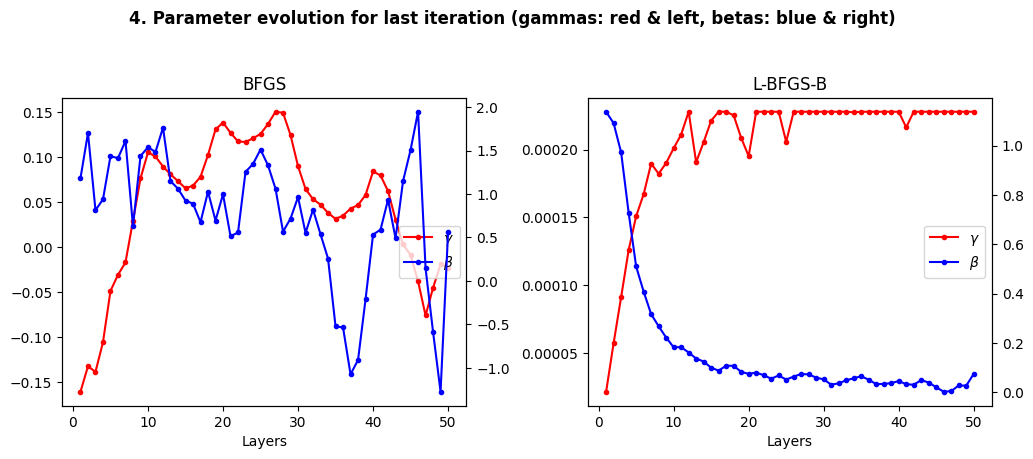

In [23]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## N=77

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
635,77,BFGS,1,0.0001,0.39,[0.000108307745618],[0.5230479893037681],1934.541313,0.022078
685,77,L-BFGS-B,1,0.0001,0.39,[0.000108307745781],[0.523047988282447],1934.541313,0.022078


**2. State at layers=50**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
684,77,BFGS,50,0.0001,0.39,9.764248,0.415022
734,77,L-BFGS-B,50,0.0001,0.39,56.238237,0.138790


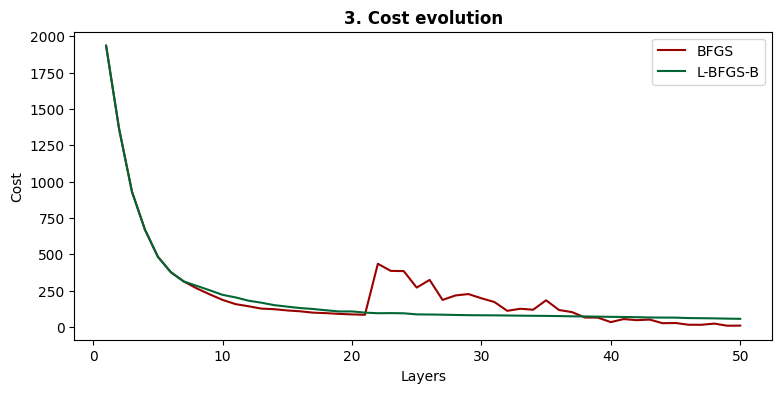

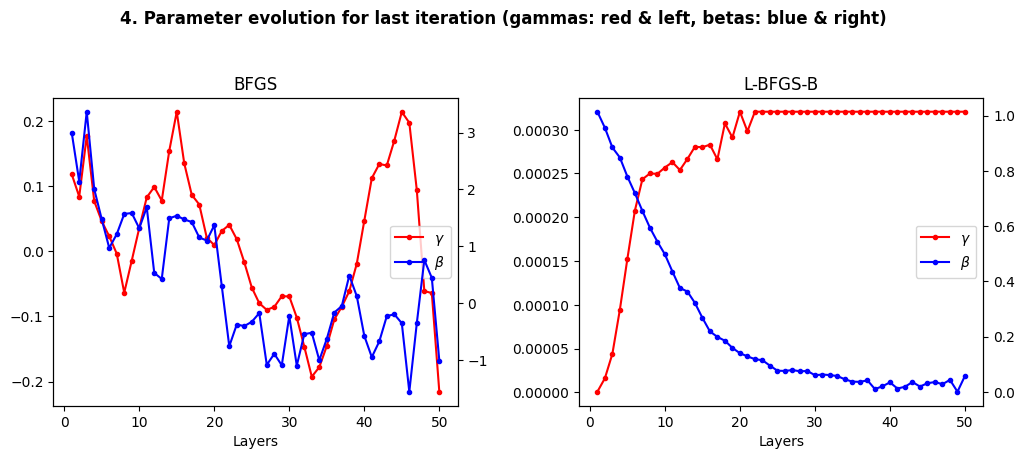

In [24]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Linear-quadratic protocol

## N=21

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
410,21,BFGS,1,0.15,1.5,[0.154564850965925],[1.5075920586575662],74.357584,0.169938
400,21,L-BFGS-B,1,0.15,1.5,[0.15456485072714302],[1.507592055147221],74.357584,0.169938


**2. State at layers=10**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
419,21,BFGS,10,0.15,1.5,1.943862e-19,1.000000
409,21,L-BFGS-B,10,0.15,1.5,3.862211e+01,0.130203


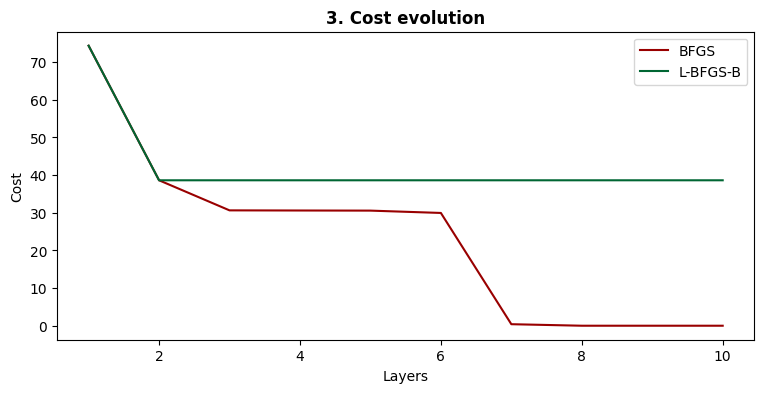

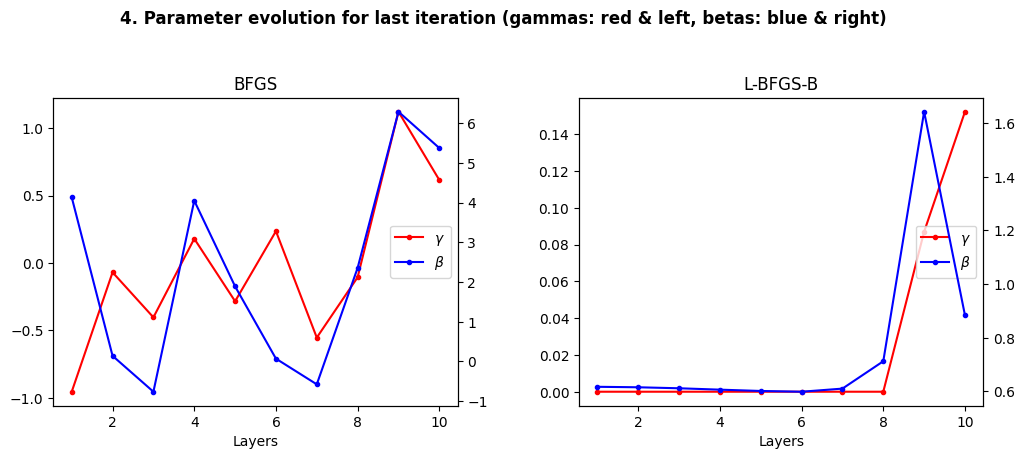

In [25]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## N=39

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
120,39,BFGS,1,0.05,1.5,[0.042419916569209],[1.46558428370015],308.614459,0.046635
150,39,L-BFGS-B,1,0.05,1.5,[0.042419916719614],[1.465584281583984],308.614459,0.046635


**2. State at layers=30**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
149,39,BFGS,30,0.05,1.5,0.018844,0.999302
179,39,L-BFGS-B,30,0.05,1.5,129.967519,0.016010


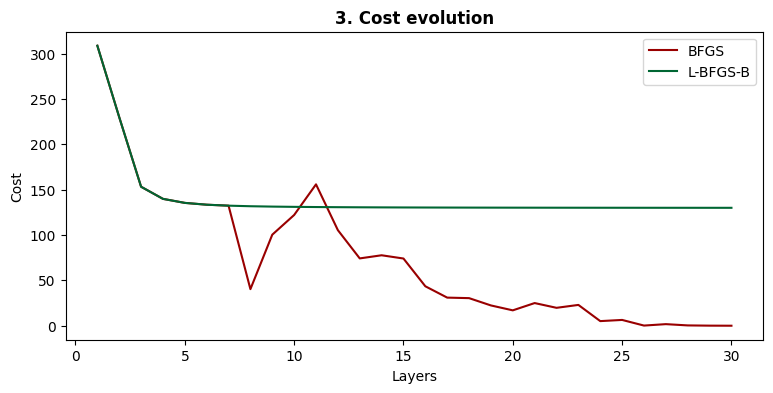

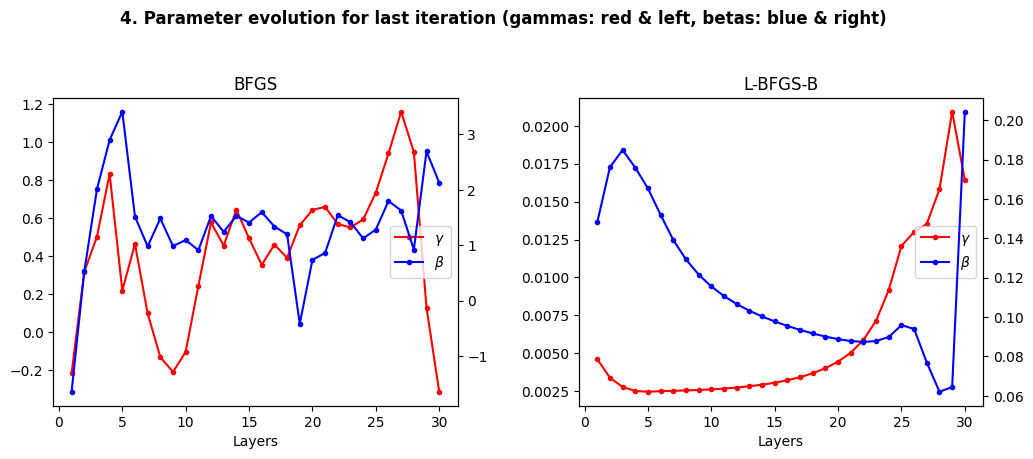

In [26]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = 30 # int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## N=51

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
515,51,BFGS,1,0.01,1.1,[0.013172117193072002],[1.071317677840412],957.604456,0.012695
545,51,L-BFGS-B,1,0.01,1.1,[0.013172117123907002],[1.071317614553077],957.604456,0.012695


**2. State at layers=30**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
544,51,BFGS,30,0.01,1.1,117.906907,0.020086
574,51,L-BFGS-B,30,0.01,1.1,217.812909,0.140718


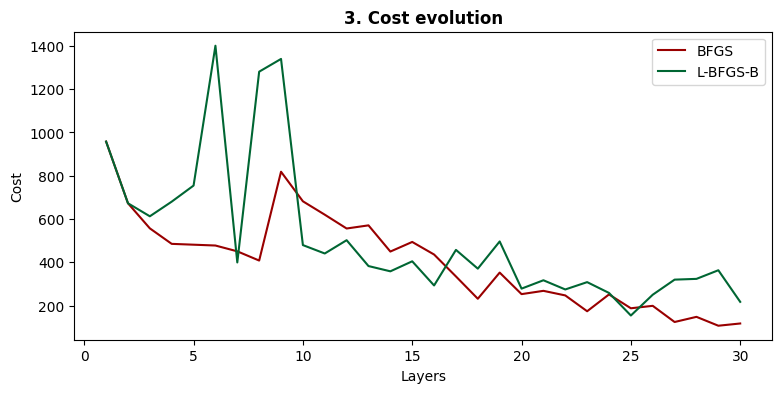

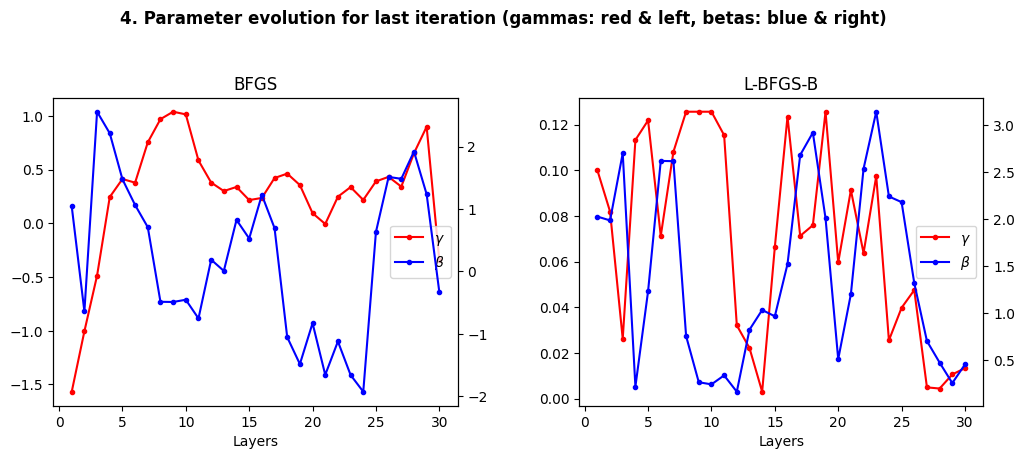

In [27]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## N=77

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
210,77,BFGS,1,0.05,2.3,[0.049794543256928],[2.270977840921084],1382.099774,0.104663
180,77,L-BFGS-B,1,0.05,2.3,[0.04979454330117],[2.270977842258782],1382.099774,0.104663


**2. State at layers=30**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
239,77,BFGS,30,0.05,2.3,140.251069,0.170240
209,77,L-BFGS-B,30,0.05,2.3,280.101396,0.019042


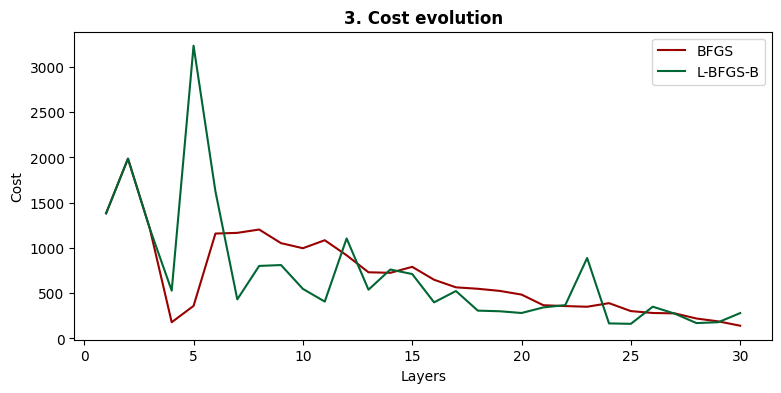

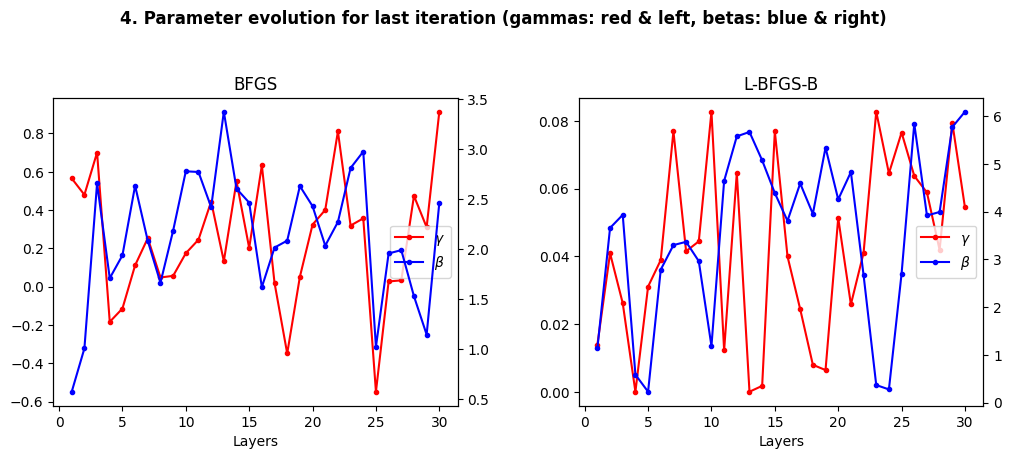

In [28]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Linear-abs protocol

## N=21

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
430,21,BFGS,1,0.15,1.5,[0.150167535914248],[1.4849625382688751],6.808984,0.174848
420,21,L-BFGS-B,1,0.15,1.5,[0.150167529669819],[1.484962492110762],6.808984,0.174848


**2. State at layers=10**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
439,21,BFGS,10,0.15,1.5,1.570371e-17,1.000000
429,21,L-BFGS-B,10,0.15,1.5,5.524890e+00,0.149457


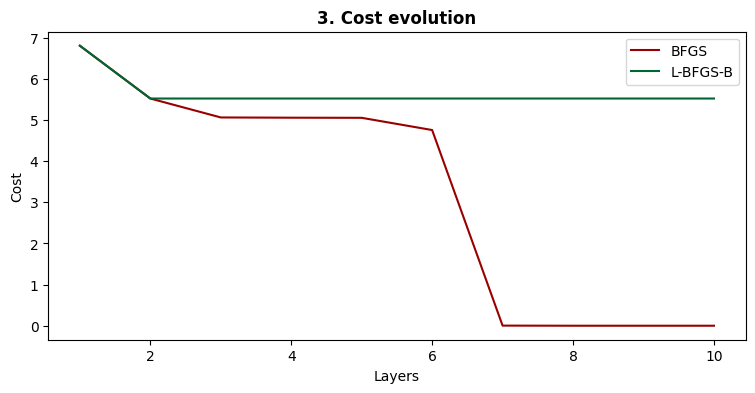

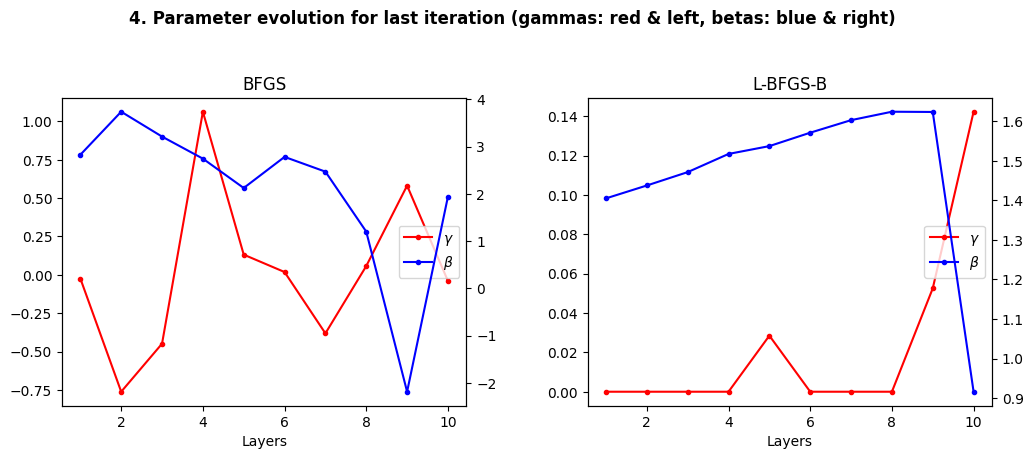

In [29]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## N=39

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
931,39,BFGS,1,0.05,1.5,[0.043914402413695],[1.491486994085921],13.621065,0.043982
961,39,L-BFGS-B,1,0.05,1.5,[0.043914402411096],[1.491486994120301],13.621065,0.043982


**2. State at layers=30**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
960,39,BFGS,30,0.05,1.5,0.016555,0.998104
990,39,L-BFGS-B,30,0.05,1.5,9.522119,0.016777


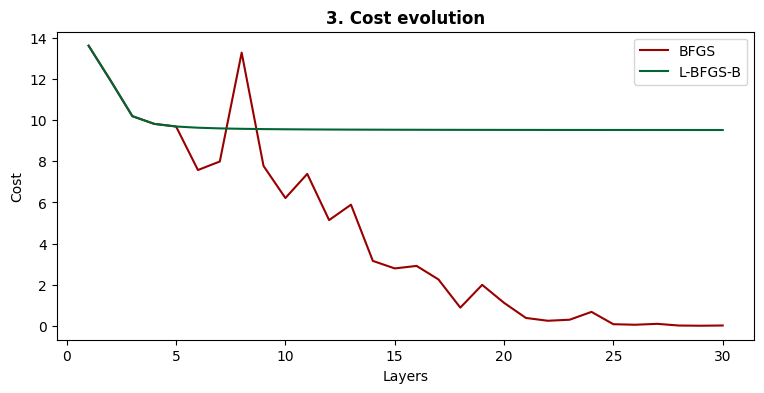

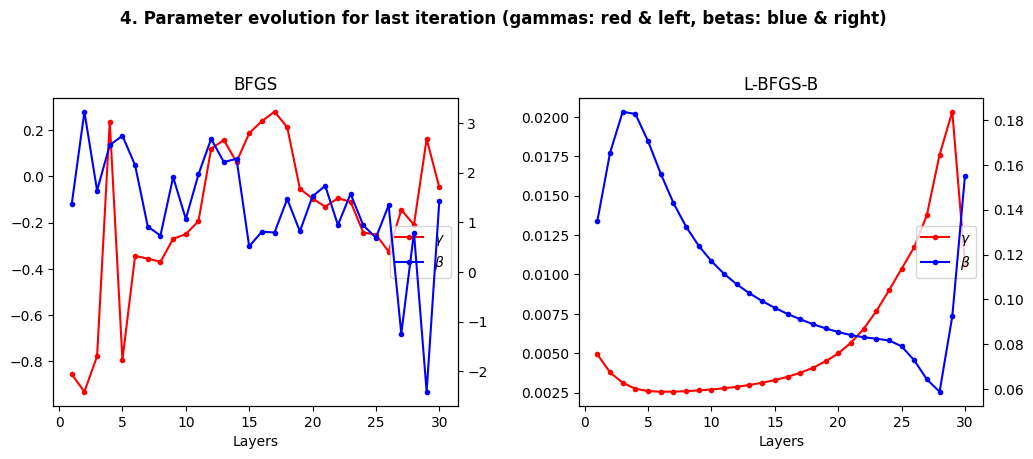

In [30]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = 30 # int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## N=51

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
575,51,BFGS,1,0.01,1.1,[0.013849093690625001],[1.070235368618127],27.227661,0.012325
605,51,L-BFGS-B,1,0.01,1.1,[0.013849093798469],[1.07023534830555],27.227661,0.012325


**2. State at layers=30**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
604,51,BFGS,30,0.01,1.1,5.581083,0.003903
634,51,L-BFGS-B,30,0.01,1.1,6.815950,0.093155


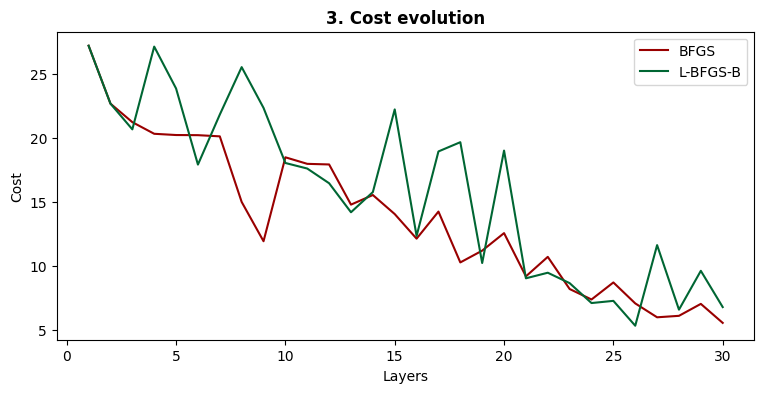

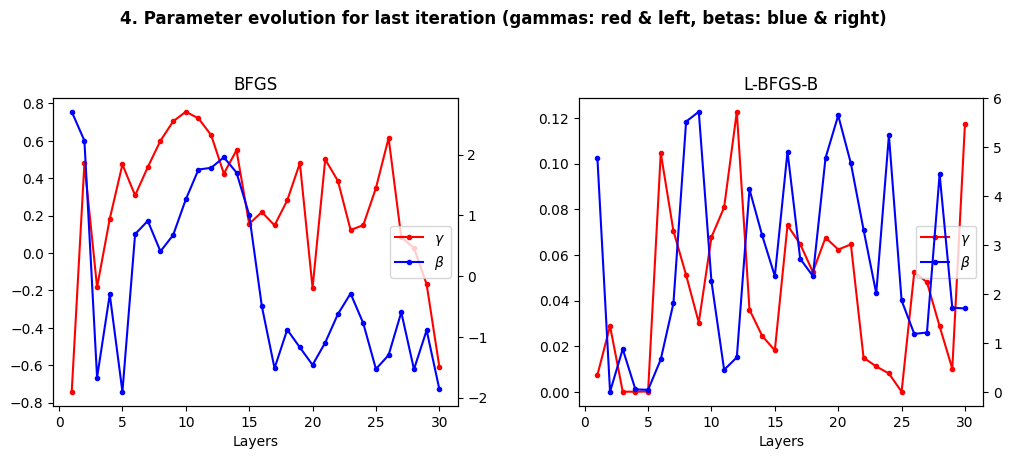

In [31]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## N=77

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
370,77,BFGS,1,0.05,2.3,[0.049438310407823004],[2.219804708201128],25.867042,0.108715
340,77,L-BFGS-B,1,0.05,2.3,[0.049438310394877005],[2.21980470665477],25.867042,0.108715


**2. State at layers=30**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
399,77,BFGS,30,0.05,2.3,5.571935,0.234359
369,77,L-BFGS-B,30,0.05,2.3,4.918732,0.711002


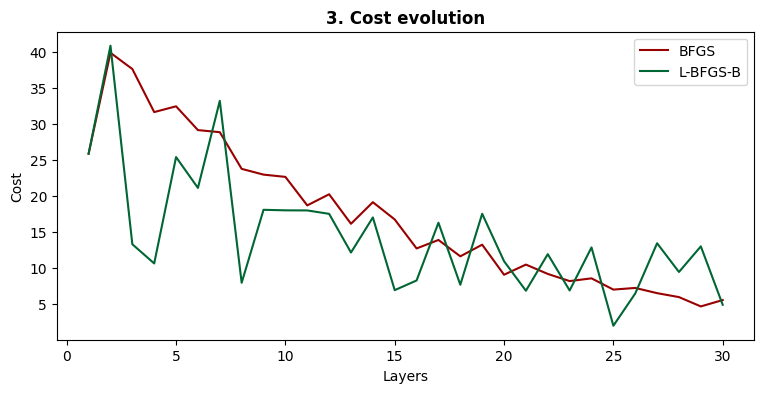

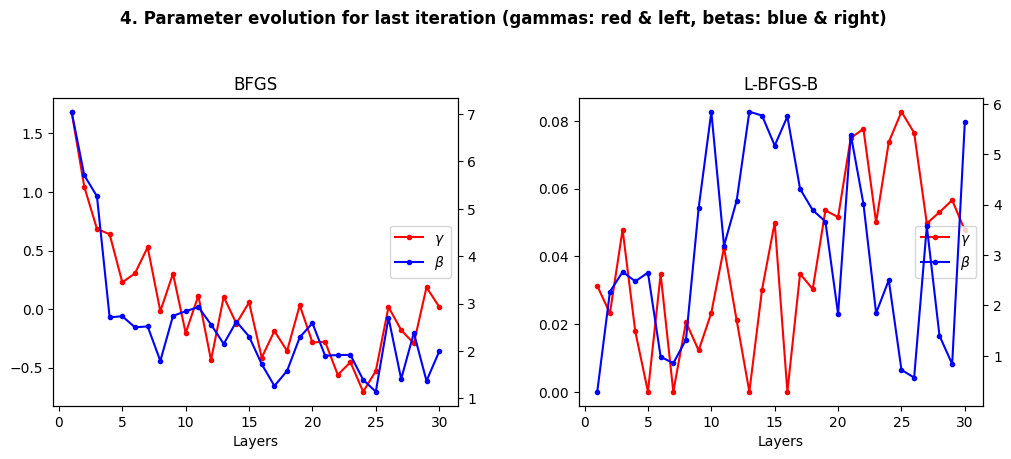

In [32]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Extras

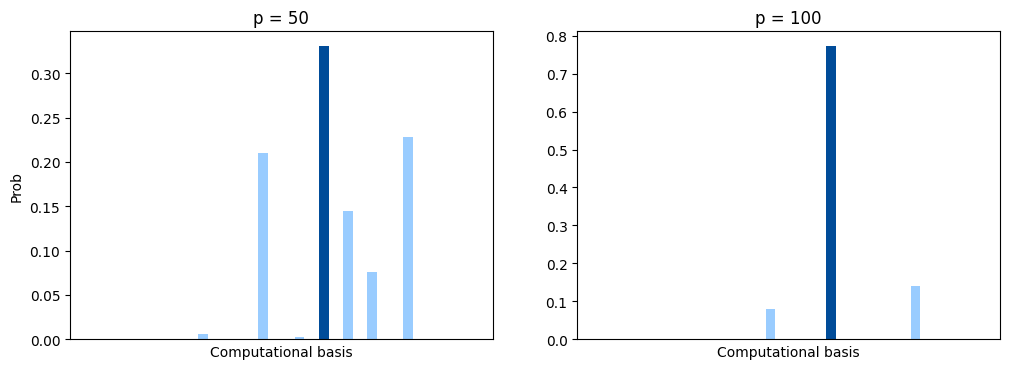

In [10]:
N = 39
gamma_0 = 0.0004
beta_0 = 0.5

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['gamma_0']==gamma_0)
                        & (experiment_results['beta_0']==beta_0)].reset_index(drop=True)

num_qubits = df.loc[0, 'num_qubits']
solutions = compute_solution(N)
x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
bar_colors = [plot_colors[1][0] if c in solutions else plot_colors[1][1] for c in x_hist]

pops_50 =  df[df['layers']==50].reset_index().loc[0, 'state_populations']
pops_100 =  df[df['layers']==100].reset_index().loc[0, 'state_populations']

fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].bar(x_hist, pops_50, color=bar_colors)
axs[1].bar(x_hist, pops_100, color=bar_colors)
axs[0].set_ylabel('Prob')
axs[0].set_xlabel('Computational basis')
axs[1].set_xlabel('Computational basis')

axs[0].set_xticks(range(2**num_qubits), "")
axs[0].xaxis.set_major_locator(ticker.NullLocator())
axs[0].set_title('p = 50')
axs[1].set_xticks(range(2**num_qubits), "")
axs[1].xaxis.set_major_locator(ticker.NullLocator())
axs[1].set_title('p = 100');

### Comparing with an unbounded method (BFGS)

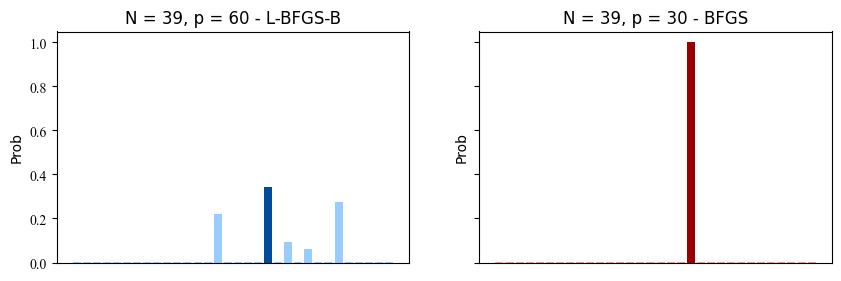

In [11]:
N = 39
gamma_0 = 0.0005
beta_0 = 0.4

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')
                        & (experiment_results['gamma_0']==gamma_0)
                        & (experiment_results['beta_0']==beta_0)].reset_index(drop=True)
fig, axs = plt.subplots(1, 2, figsize=(10,3), sharey=True)

for j, optimizer in enumerate(['L-BFGS-B', 'BFGS']):
    df_j = df[df['optimizer']==optimizer].reset_index()
    idx_last_layer = df_j['layers'].idxmax()
    num_qubits = df_j.loc[idx_last_layer, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    pops =  df_j.loc[idx_last_layer, 'state_populations']

    bar_colors = [plot_colors[j+1][0] if c in solutions else plot_colors[j+1][1] for c in x_hist]

    axs[j].bar(x_hist, pops, color=bar_colors)
    axs[j].set_ylabel('Prob')

    labels = (axs[j].get_xticklabels() + axs[j].get_yticklabels())

    for label in labels:
        label.set_fontname('Times New Roman')

    axs[j].set_xticks(range(2**num_qubits), "")
    axs[j].xaxis.set_major_locator(ticker.NullLocator())
    p = df_j.loc[idx_last_layer, 'layers']
    axs[j].set_title(f'N = {N}, p = {p} - {optimizer}')

    if i == len(Ns)-1:
        axs[j].set_xlabel('Computational basis')

**1. Minimum for one layer QAOA**

,N,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
0,39,1,0.0004,0.4,[0.00044577565739700004],[0.524478674007806],488.233997,0.045932


**2. State at layers=50**

,N,layers,gamma_0,beta_0,cost,fidelity
29,39,30,0.0004,0.4,0.031106,0.998556


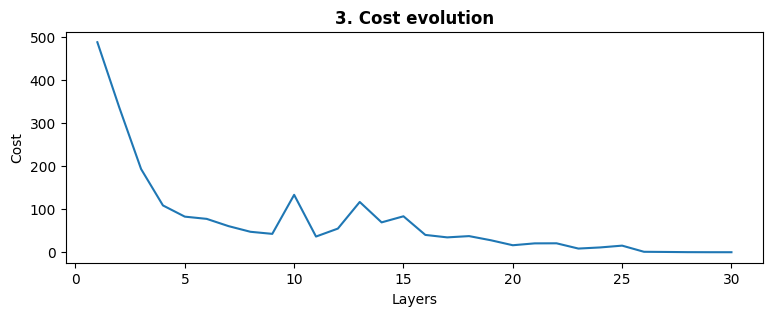

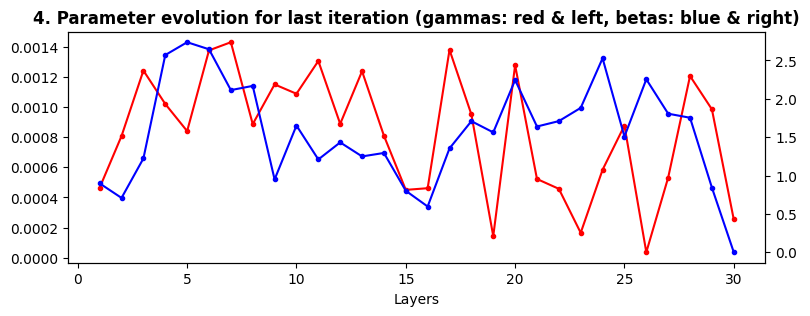

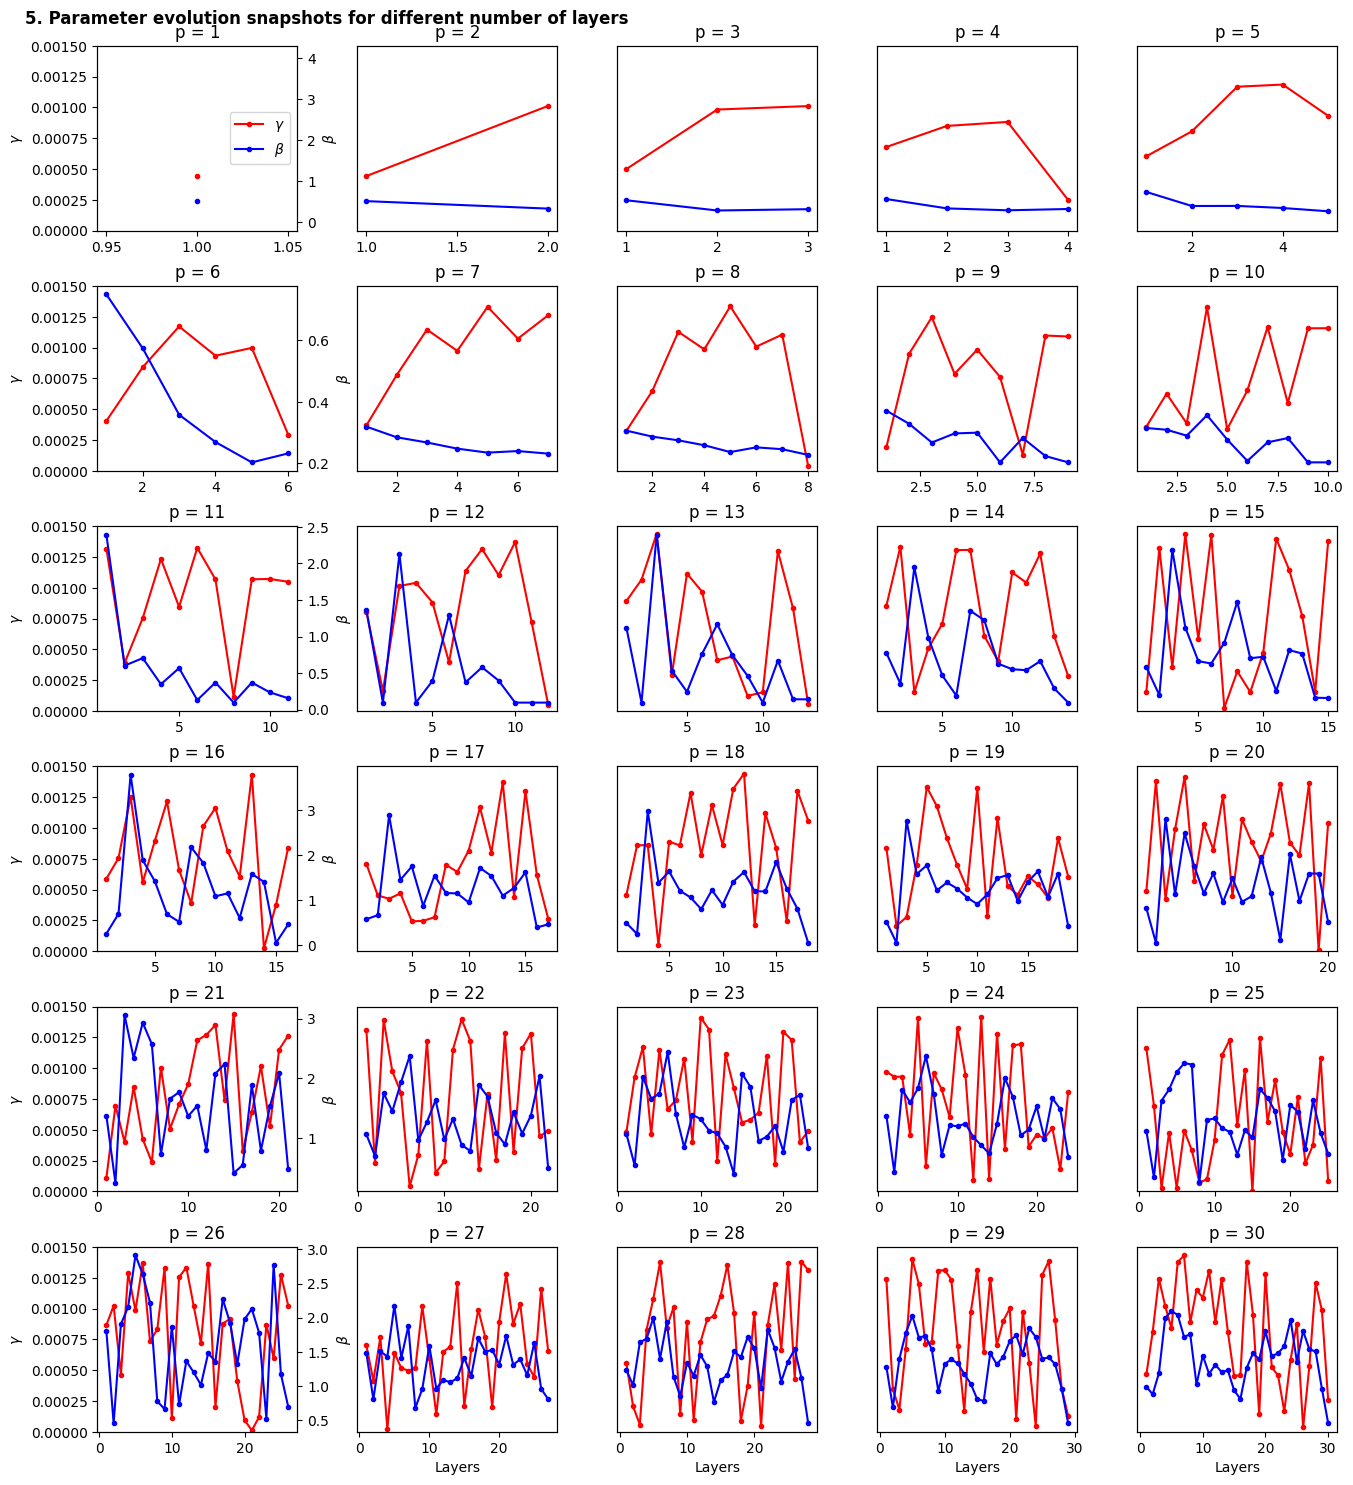

In [ ]:
N = 39
gamma_0 = 0.0004
beta_0 = 0.4

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')
                        & (experiment_results['gamma_0']==gamma_0)
                        & (experiment_results['beta_0']==beta_0)
                        & (experiment_results['optimizer']=='BFGS')
                        ].reset_index(drop=True)

display(Markdown("**1. Minimum for one layer QAOA**"))
display(df[df['layers']==1][['N', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('beta_0'))

display(Markdown("**2. State at layers=30**"))
display(df[df['layers']==30][['N', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('beta_0'))

fig, ax = plt.subplots(1, 1, figsize=(9, 3))
ax.plot('layers', 'cost', data=df)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.set_title('3. Cost evolution', fontweight='bold')


fig, ax = plt.subplots(1, 1, figsize=(9, 3))
sec_ax = ax.twinx()
max_layer_idx = df['layers'].idxmax()
max_layer = df.loc[max_layer_idx, 'layers']
gammas = df.loc[max_layer_idx, 'gammas']
betas = df.loc[max_layer_idx, 'betas']
ax.plot(range(1, max_layer+1), gammas, marker='.', color='red')
sec_ax.plot(range(1, max_layer+1), betas, marker='.', color='blue')
ax.set_xlabel('Layers')
ax.set_title('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold')



layers = sorted(df['layers'].unique())
ncols = 5
nrows = int(len(layers)/ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 3*nrows), sharey=True)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
sec_axs = np.empty_like(axs, dtype=object)
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        sec_axs[i, j] = axs[i, j].twinx()
axs = axs.flatten()
sec_axs = sec_axs.flatten()
fig.suptitle("5. Parameter evolution snapshots for different number of layers", x=0.08, y=0.90, ha='left', fontweight='bold')
for idx, p in enumerate(layers):
        df_i = df[(df['layers']==p)].reset_index()
        ax = axs[idx]
        sec_ax = sec_axs[idx]
        if not df_i.empty:
            gammas = df_i.loc[0, 'gammas']
            betas = df_i.loc[0, 'betas']
            ax.plot(range(1, len(gammas)+1), gammas, marker='.', color='red', label='$\\gamma$')
            sec_ax.plot(range(1, len(betas)+1), betas, marker='.', color='blue', label='$\\beta$')
            
            ax.set_title(f'p = {p}')
            if idx % ncols == 0:
                ax.set_ylabel('$\\gamma$')
                sec_ax.set_ylabel('$\\beta$')
            if idx > len(axs) - ncols:
                 ax.set_xlabel('Layers')
            if idx % ncols > 0:
                ax.get_yaxis().set_visible(False)
                sec_ax.get_yaxis().set_visible(False)
                sec_ax.sharey(sec_axs[0])

            if idx < 5:
                ax.set_ylim(0,0.0015)
            
            if idx == 0:
                lines, labels = ax.get_legend_handles_labels()
                lines2, labels2 = sec_ax.get_legend_handles_labels()
                sec_ax.legend(lines + lines2, labels + labels2, loc='center right')

### All numbers

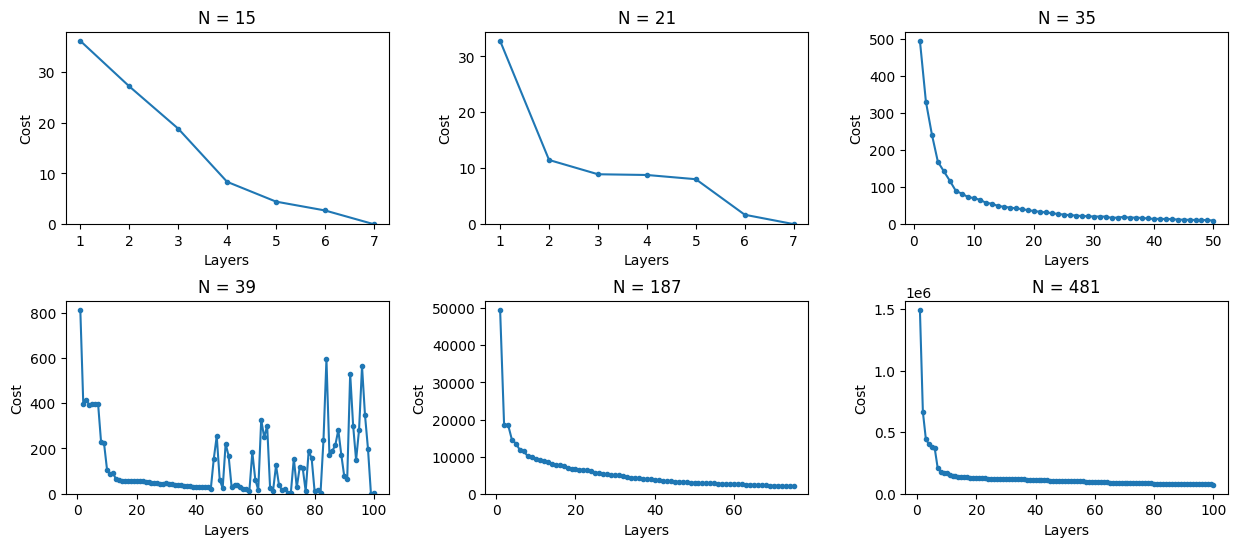

In [13]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')]
df = df.groupby(['N','layers']).last().reset_index()

Ns = sorted(df['N'].unique())
optimizers = sorted(experiment_results['optimizer'].unique())
setups = sorted(experiment_results['setup'].unique(), reverse=True)

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()
for i, N in enumerate(Ns):
    df_N = df[df['N']==N]
    axs[i].plot('layers', 'cost', data=df_N, marker='.')
    axs[i].set_ylabel('Cost')
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)
    axs[i].set_title(f'N = {N}')

for j in range(len(Ns), len(axs)):
    axs[j].remove()

plt.show()

# plt.savefig('../report_1/img/cost_layers.pdf')

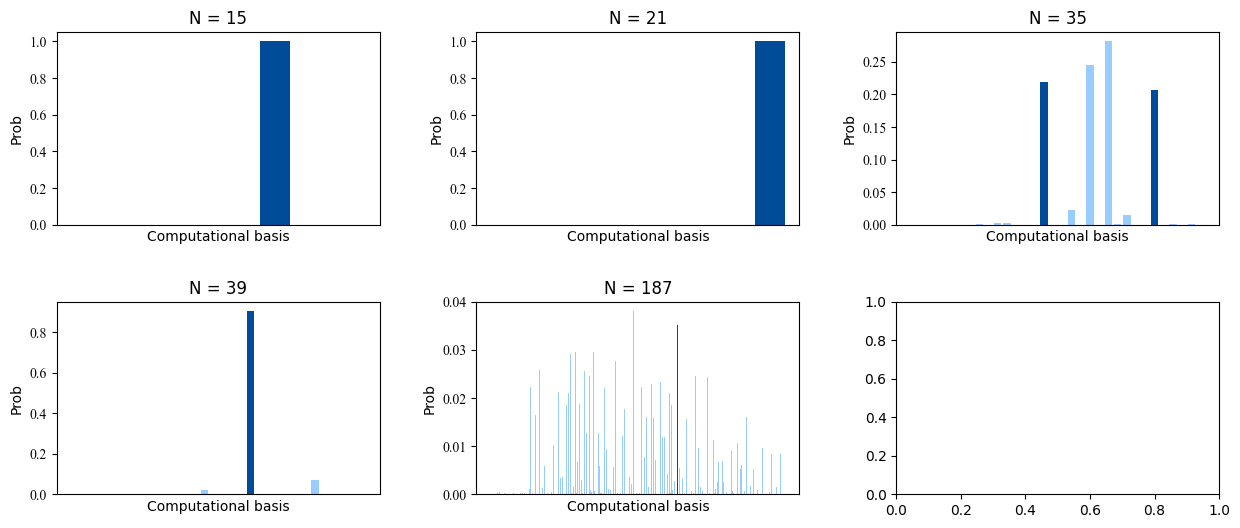

In [14]:
df = experiment_results[(experiment_results['setup']=='standard') & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']<=187)]
df = df.groupby(['N','layers']).last().reset_index()
Ns = sorted(df['N'].unique())

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()

for i, N in enumerate(Ns):
    df_N = df[df['N']==N].reset_index()
    idx_last_layer = df_N['layers'].idxmax()
    num_qubits = df_N.loc[idx_last_layer, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    pops =  df_N.loc[idx_last_layer, 'state_populations']

    bar_colors = [plot_colors[1][0] if c in solutions else plot_colors[1][1] for c in x_hist]

    axs[i].bar(x_hist, pops, color=bar_colors)
    axs[i].set_ylim(0)
    axs[i].set_ylabel('Prob')
    axs[i].set_xlabel('Computational basis')

    labels = (axs[i].get_xticklabels() + axs[i].get_yticklabels())

    for label in labels:
        label.set_fontname('Times New Roman')

    axs[i].set_xticks(range(2**num_qubits), "")
    axs[i].xaxis.set_major_locator(ticker.NullLocator())
    axs[i].set_title(f'N = {N}')

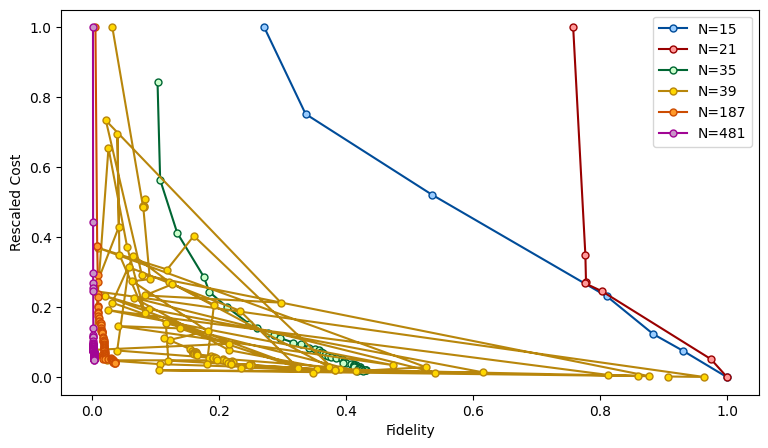

In [15]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','layers']).last().reset_index()
Ns = sorted(df['N'].unique())

fig = plt.figure(figsize=(9,5))

for i, N in enumerate(Ns):
    df_N = df[df['N']==N]
    plt.plot(df_N['fidelity'], df_N['cost_rescaled'], label=f'N={N}',
             color=plot_colors[i+1][0], mec=plot_colors[i+1][0], mfc=plot_colors[i+1][1], marker='.',
             markersize=10)

plt.xlabel('Fidelity')
plt.ylabel('Rescaled Cost')
#plt.yscale('log')
plt.legend(loc='best')
#plt.show()

# plt.savefig('../report_1/img/cost_fidelity.pdf')

In [16]:
# df = experiment_results[(experiment_results['setup']=='standard')
#                         & (experiment_results['optimizer']=='L-BFGS-B')
#                         & (experiment_results['N']>=35)
#                         & (experiment_results['N']!=119)]

# Ns = sorted(df['N'].unique())

# n_samples = 4
# fig, axs = plt.subplots(nrows=len(Ns), ncols=n_samples, figsize=(24, len(Ns)*2.8),sharex=True, sharey='row')
# fig.subplots_adjust(wspace=0.1)

# for idx_row, N in enumerate(Ns):
#     df_N = df[(df['N']==N)]

#     layer_max = df_N['layers'].max()
#     n_samples = 4
#     target_layers = [1, int(1+0.1*(layer_max-1)), int(1+0.5*(layer_max-1)), layer_max]
    
#     for idx_col, p in enumerate(target_layers):
        
#         df_p = df_N[df_N['layers']==p].copy()
#         ax = axs[idx_row][idx_col]

#         rescaled_energies_all = []
#         probs_all = []

#         for _, row in df_p.iterrows():
#             probs = row['state_populations']
#             energies = np.array(row['Ec'])

#             E_min = np.min(energies)
#             E_max = np.max(energies)
#             rescaled_E = (energies - E_min) / (E_max - E_min)

#             rescaled_energies_all.extend(rescaled_E)
#             probs_all.extend(probs)

#         # Plot using hexbin for density
#         gridsize=60 if N < 187 else 100
#         hb = ax.hexbin(rescaled_energies_all, probs_all,
#                        gridsize=gridsize, cmap='plasma', bins='log', yscale='log')
                       
#         ax.set_xlim(-0.01,1.01)
        
#         ax.set_title(f'p = {p}', fontsize='large', fontweight='medium')
#         if idx_col == 0:
#             ax.set_ylabel('$P$')
#         if idx_row == len(Ns)-1:
#             ax.set_xlabel('$\\tilde{E}$')

#         # Convert to NumPy arrays
#         rescaled_energies_all = np.array(rescaled_energies_all)
#         probs_all = np.array(probs_all)

#         x = sorted(np.unique(rescaled_energies_all))
#         y = []

#         for e in x:
#             idcs = np.where(rescaled_energies_all==e)
#             probs = probs_all[idcs]
#             y.append(np.average(probs))

#         smoothed = lowess(y, x, frac=0.1)
#         # ax.plot(smoothed[:,0], smoothed[:,1], color='green', linewidth=1)
#         # ylim = 1e-6 if N < 187 else 1e-7
#         # ax.set_ylim(ylim)

#     # Get vertical center of any subplot in the row (e.g., first column)
#     ax_row = axs[idx_row][0]
#     pos = ax_row.get_position()
#     y_center = (pos.y0 + pos.y1) / 2

#     # Add label to the left of the row
#     fig.text(0.08, y_center, f'N={N}', va='center', ha='right', fontsize='large', fontweight='medium', rotation=90)


# # Color bar for density
# fig.colorbar(hb, ax=axs, label='log(count)', shrink=0.4)

# # plt.show()

# # plt.savefig('../report_1/img/prob_eigenstates.pdf')

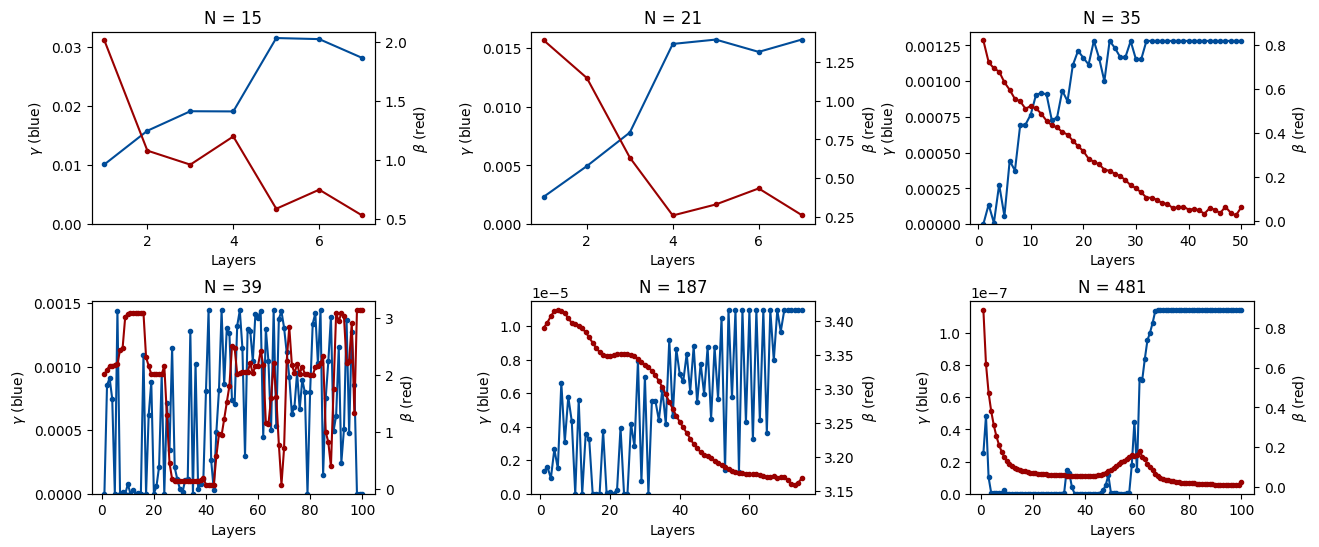

In [17]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','layers']).last().reset_index()

Ns = sorted(df['N'].unique())
optimizers = sorted(experiment_results['optimizer'].unique())

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.55)
axs = axs.flatten()
for i, N in enumerate(Ns):
    df_N = df[df['N']==N].reset_index()
    idx_last_layer = df_N['layers'].idxmax()
    layers = df_N.loc[idx_last_layer, 'layers']
    gammas =  df_N.loc[idx_last_layer, 'gammas']
    betas = df_N.loc[idx_last_layer, 'betas']

    ax1 = axs[i]
    ax2 = ax1.twinx()

    ax1.plot(range(1,layers+1), gammas, marker='.', color=plot_colors[1][0])
    ax1.set_ylabel('$\\gamma$ (blue)')

    ax2.plot(range(1,layers+1), betas, marker='.', color=plot_colors[2][0])
    ax2.set_ylabel('$\\beta$ (red)')
    
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)
    axs[i].set_title(f'N = {N}')

for j in range(len(Ns), len(axs)):
    axs[j].remove()

# plt.savefig('../report_1/img/angle_evolution.pdf')

### Comparing with an unbounded method (BFGS)

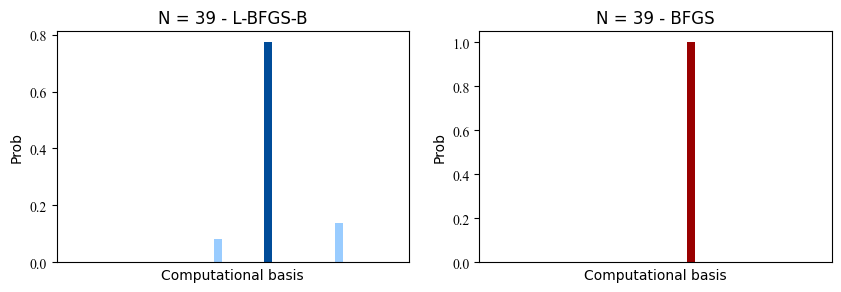

In [18]:
N = 39
gamma_0 = 0.0004
beta_0 = 0.5

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')
                        & (experiment_results['gamma_0']==gamma_0)
                        & (experiment_results['beta_0']==beta_0)].reset_index(drop=True)
fig, axs = plt.subplots(1, 2, figsize=(10,3))

for j, optimizer in enumerate(['L-BFGS-B', 'BFGS']):
    df_j = df[df['optimizer']==optimizer].reset_index()
    idx_last_layer = df_j['layers'].idxmax()
    num_qubits = df_j.loc[idx_last_layer, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    pops =  df_j.loc[idx_last_layer, 'state_populations']

    bar_colors = [plot_colors[j+1][0] if c in solutions else plot_colors[j+1][1] for c in x_hist]

    axs[j].bar(x_hist, pops, color=bar_colors)
    axs[j].set_ylim(0)
    axs[j].set_ylabel('Prob')

    labels = (axs[j].get_xticklabels() + axs[j].get_yticklabels())

    for label in labels:
        label.set_fontname('Times New Roman')

    axs[j].set_xticks(range(2**num_qubits), "")
    axs[j].xaxis.set_major_locator(ticker.NullLocator())
    axs[j].set_title(f'N = {N} - {optimizer}')

    if i == len(Ns)-1:
        axs[j].set_xlabel('Computational basis')

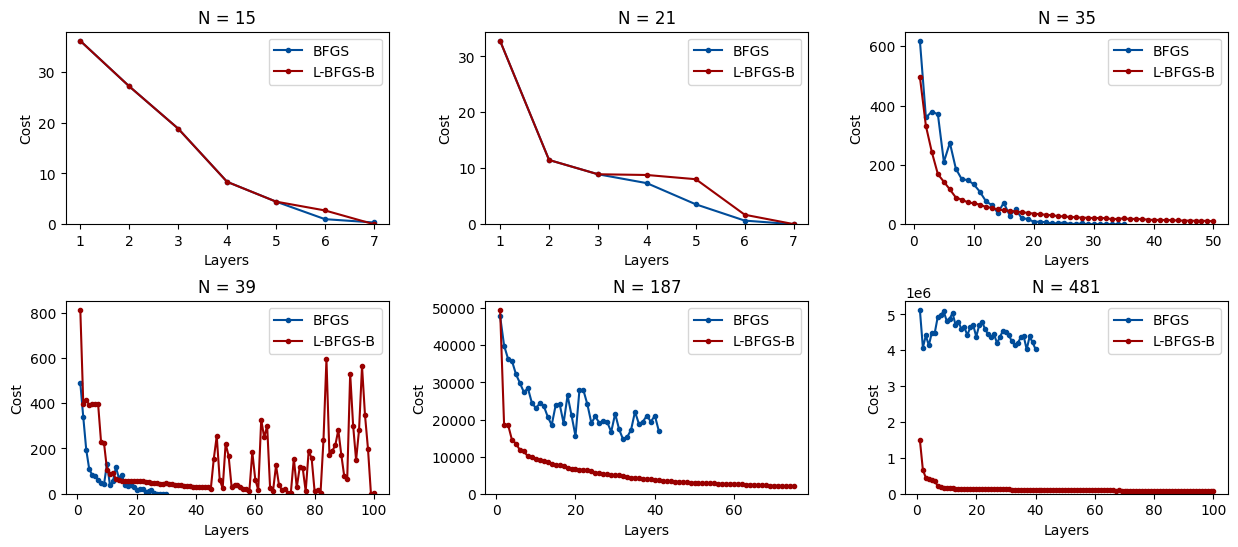

In [19]:
df = experiment_results[(experiment_results['setup']=='standard')&(experiment_results['N']!=119)]
df = df.groupby(['N','layers', 'optimizer']).last().reset_index()

Ns = sorted(df['N'].unique())
optimizers = ['BFGS', 'L-BFGS-B']
setups = sorted(experiment_results['setup'].unique(), reverse=True)

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()
for i, N in enumerate(Ns):
    for j, optimizer in enumerate(optimizers):
        df_N = df[(df['N']==N) & (df['optimizer']==optimizer)]
        axs[i].plot('layers', 'cost', data=df_N, marker='.', label=optimizer, color=plot_colors[j+1][0])
    
    axs[i].set_ylabel('Cost')
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)
    axs[i].set_title(f'N = {N}')
    axs[i].legend(loc='best')

for j in range(len(Ns), len(axs)):
    axs[j].remove()

# plt.savefig('../report_1/img/unbounded_cost_evolution.pdf')

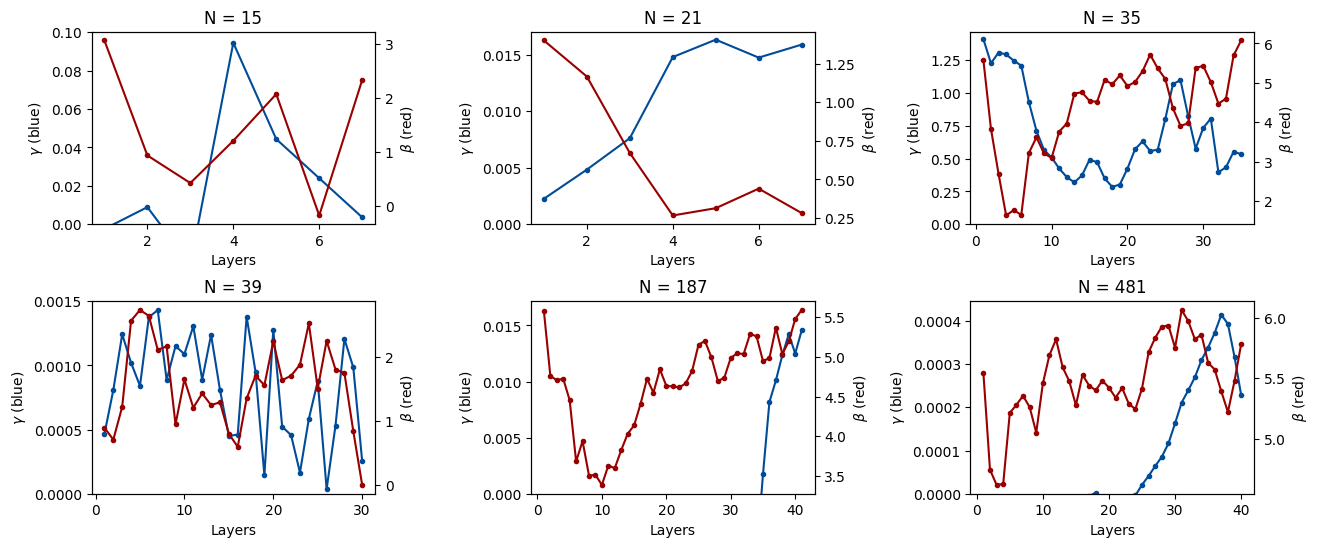

In [20]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='BFGS')
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','layers']).last().reset_index()

Ns = sorted(df['N'].unique())
optimizers = sorted(experiment_results['optimizer'].unique())

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.55)
axs = axs.flatten()
for i, N in enumerate(Ns):
    df_N = df[df['N']==N].reset_index()
    idx_last_layer = df_N['layers'].idxmax()
    layers = df_N.loc[idx_last_layer, 'layers']
    gammas =  df_N.loc[idx_last_layer, 'gammas']
    betas = df_N.loc[idx_last_layer, 'betas']

    ax1 = axs[i]
    ax2 = ax1.twinx()

    ax1.plot(range(1,layers+1), gammas, marker='.', color=plot_colors[1][0])
    ax1.set_ylabel('$\\gamma$ (blue)')

    ax2.plot(range(1,layers+1), betas, marker='.', color=plot_colors[2][0])
    ax2.set_ylabel('$\\beta$ (red)')
    
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)
    axs[i].set_title(f'N = {N}')

for j in range(len(Ns), len(axs)):
    axs[j].remove()

# plt.savefig('../report_1/img/angle_evolution_unbounded.pdf')

## Our Method

**1. Minimum for one layer QAOA**

,N,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
1018,39,1,0.0005,0.4,[-0.011238509937121001],[0.37964357974725604],23.876367,0.029038


**2. State at layers=50**

,N,layers,gamma_0,beta_0,cost,fidelity


ValueError: attempt to get argmax of an empty sequence

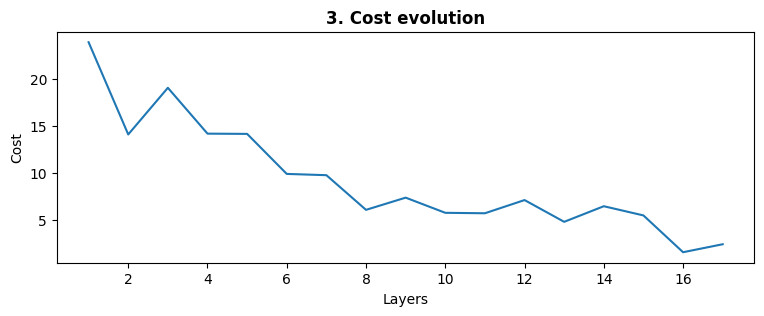

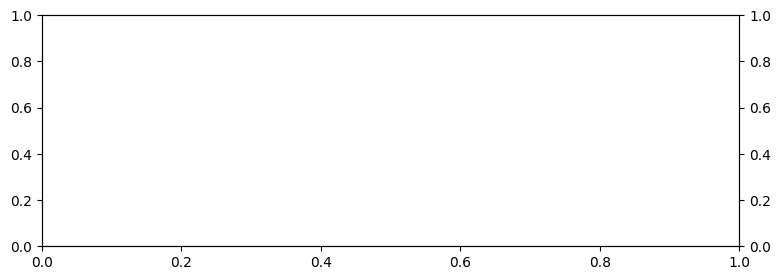

In [7]:
N = 39
gamma_0 = 0.0005
beta_0 = 0.4

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['gamma_0']==gamma_0)
                        & (experiment_results['beta_0']==beta_0)]

display(Markdown("**1. Minimum for one layer QAOA**"))
display(df[df['layers']==1][['N', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('beta_0'))

display(Markdown("**2. State at layers=50**"))
display(df[df['layers']==50][['N', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('beta_0'))

fig, ax = plt.subplots(1, 1, figsize=(9, 3))
ax.plot('layers', 'cost', data=df)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.set_title('3. Cost evolution', fontweight='bold')


fig, ax = plt.subplots(1, 1, figsize=(9, 3))
sec_ax = ax.twinx()
max_layer_idx = df[df['layers']==50]['layers'].idxmax() # df['layers'].idxmax()
max_layer = df.loc[max_layer_idx, 'layers']
gammas = df.loc[max_layer_idx, 'gammas']
betas = df.loc[max_layer_idx, 'betas']
ax.plot(range(1, max_layer+1), gammas, marker='.', color='red')
sec_ax.plot(range(1, max_layer+1), betas, marker='.', color='blue')
ax.set_xlabel('Layers')
ax.set_title('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold')



layers = df[df['layers']<=50]['layers'].unique() # df['sorted(df['layers'].unique())
ncols = 5
nrows = int(len(layers)/ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 3*nrows), sharey=True)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
sec_axs = np.empty_like(axs, dtype=object)
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        sec_axs[i, j] = axs[i, j].twinx()
axs = axs.flatten()
sec_axs = sec_axs.flatten()
fig.suptitle("5. Parameter evolution snapshots for different number of layers", x=0.08, y=0.90, ha='left', fontweight='bold')
for idx, p in enumerate(layers):
        df_i = df[(df['layers']==p)].reset_index()
        ax = axs[idx]
        sec_ax = sec_axs[idx]
        if not df_i.empty:
            gammas = df_i.loc[0, 'gammas']
            betas = df_i.loc[0, 'betas']
            ax.plot(range(1, len(gammas)+1), gammas, marker='.', color='red', label='$\\gamma$')
            sec_ax.plot(range(1, len(betas)+1), betas, marker='.', color='blue', label='$\\beta$')
            
            ax.set_title(f'p = {p}')
            if idx % ncols == 0:
                ax.set_ylabel('$\\gamma$')
                sec_ax.set_ylabel('$\\beta$')
            if idx > len(axs) - ncols:
                 ax.set_xlabel('Layers')
            if idx % ncols > 0:
                ax.get_yaxis().set_visible(False)
                sec_ax.get_yaxis().set_visible(False)
                sec_ax.sharey(sec_axs[0])
            
            if idx == 0:
                lines, labels = ax.get_legend_handles_labels()
                lines2, labels2 = sec_ax.get_legend_handles_labels()
                sec_ax.legend(lines + lines2, labels + labels2, loc='center right')